# Descripción del proyecto

El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un modelo que determine el valor de mercado.
A Rusty Bargain le interesa:
- la calidad de la predicción;
- la velocidad de la predicción;
- el tiempo requerido para el entrenamiento

# Tabla de Contenido

* [1 Preparacion de datos](#1)
    * [1.1 Chequeo de Valores Anormales]()
    * [1.2 Chequeo del valor 'other' en las columnas model, vehicle_type y fuel_type]()
    * [1.3 Chequeo de la columna 'registration_year']()
    * [1.4 Convertir los valores anormales a Nan]()
    * [1.5 Análisis de Valores Ausentes]()
        * [1.5.1 Rellenamos los valores en la columna 'model']()
        * [1.5.2 Rellenamos los valores en la columna 'power']()
        * [1.5.3 Rellenamos los valores en la columna 'vehicle_type']()
        * [1.5.4 Rellenamos los valores en la columna 'fuel_type']()
        * [1.5.5 Rellenamos los valores en la columna 'gearbox']()
        * [1.5.6 Rellenamos los valores en la columna 'not_repaired']()
    * [1.6 Análisis de Valores Duplicados]()
    * [1.7 Determinar Valores Faltantes]()
* [2. EDA]()
    * [2.1 Visualizacion de las Variables Continuas]()
    * [2.2 Visualizacion de las Variables Categóricas]()
* [3. Entrenamiento del Modelo]()
    * [3.1 Proceso de Train Test Split]()
    * [3.2 One-Hot Encoding]()
    * [3.3 Ordinal Encoding]()
* [4 Análisis del modelo]()
    * [4.1 Regresión Lineal]()
    * [4.2 Bosque Aleatorio]()
    * [4.3 XGBoost]()
    * [4.4 LightGBM]()
    * [4.5 CatBoost]()
* [5 Conclusiones]()




## Preparación de datos

In [1]:
!pip install sidetable
!pip install catboost

In [2]:
# cargamos las librerías

import pandas as pd
import regex as re
import numpy as np
import sidetable as stb
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from collections import defaultdict
import warnings
warnings.simplefilter('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgbm
import catboost as cb

from sklearn.model_selection import GridSearchCV




In [3]:
# cargamos el dataframe

df = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/car_data.csv')

table = pd.DataFrame

In [4]:
# mostramos una vista previa del DataFrame

df.sample(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
126323,10/03/2016 16:56,4800,NaN,2006,NaN,0,zafira,125000,0,NaN,opel,NaN,10/03/2016 00:00,0,12305,05/04/2016 16:45
129410,02/04/2016 16:58,5990,sedan,2005,manual,122,1er,150000,1,gasoline,bmw,yes,02/04/2016 00:00,0,45309,02/04/2016 17:40
281131,19/03/2016 12:42,600,sedan,1997,manual,75,escort,125000,5,petrol,ford,no,19/03/2016 00:00,0,45899,20/03/2016 14:16
220407,21/03/2016 23:51,1199,sedan,1989,manual,75,other,150000,8,gasoline,mercedes_benz,yes,21/03/2016 00:00,0,41812,22/03/2016 06:40
93614,30/03/2016 19:50,8000,sedan,2005,manual,0,a4,100000,6,petrol,audi,NaN,30/03/2016 00:00,0,59073,07/04/2016 11:45
162515,24/03/2016 12:37,500,sedan,1996,manual,102,3er,150000,3,petrol,bmw,no,24/03/2016 00:00,0,97828,07/04/2016 03:16
264993,14/03/2016 16:59,18800,coupe,2008,manual,265,a5,150000,4,petrol,audi,no,14/03/2016 00:00,0,63936,06/04/2016 00:15
202576,05/04/2016 10:50,1000,small,1999,manual,60,clio,150000,3,petrol,renault,no,05/04/2016 00:00,0,24148,07/04/2016 14:32
147416,17/03/2016 13:52,4000,bus,2002,auto,150,sharan,150000,12,petrol,volkswagen,no,17/03/2016 00:00,0,32139,17/03/2016 14:42
188758,14/03/2016 15:56,6200,bus,2004,manual,116,alhambra,125000,9,gasoline,seat,no,14/03/2016 00:00,0,84434,05/04/2016 19:44


In [5]:
# modificamos los nombres de las columnas

index_obj = df.columns

index_list = [str(item) for item in index_obj.tolist()]

def to_snake_case(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

df.columns = [to_snake_case(item) for item in index_list]
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'mileage', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen'],
      dtype='object')

In [6]:
# mostramos información general del DataFrame

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   mileage             354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  not_repaired        283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

In [7]:
# mostramos información estadística del DataFrame

df.describe()

,price,registration_year,power,mileage,registration_month,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


**Notas:**

1. En la columna 'price', podemos observar que su valor mínimo es de 0, eso significa que hay autos que no le colocaron precio o son gratis.

2. En la columna 'power', podemos ver que su valor mínimo es de 0, eso concluye que esta dañado o no le colocaron el CV, mientras que su valor máximo es de 20000, siendo algo falso, ya que los autos comerciales más rápidos alcanzan como máximo unos 1200 CV.

3. La columna 'number_of_pictures' no muestra información determinante, lo cual se obviará.

### Chequeo de Valores Anormales

In [8]:
# observamos la incidencia del valore anormal 0 en la columna 'power'

pd.DataFrame(df['power'].value_counts().reset_index()).head(10)

,index,power
0,0,40225
1,75,24023
2,60,15897
3,150,14590
4,101,13298
5,140,12852
6,90,12734
7,116,11918
8,105,10355
9,170,10121


### Chequeo del valor 'other' en las columnas model, vehicle_type y fuel_type

In [9]:
# chequeo del valor 'other' en la columna 'model'

df.loc[df.loc[:, 'model'] == 'other'].head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
7,21/03/2016 18:54,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,21/03/2016 00:00,0,19348,25/03/2016 16:47
24,13/03/2016 20:40,500,sedan,1990,manual,118,other,150000,10,petrol,mercedes_benz,yes,13/03/2016 00:00,0,35390,13/03/2016 20:40
38,01/04/2016 17:45,11900,other,2002,manual,129,other,150000,11,gasoline,volkswagen,no,01/04/2016 00:00,0,10551,05/04/2016 12:47
39,25/03/2016 15:50,1500,bus,1984,manual,70,other,150000,8,gasoline,mercedes_benz,no,25/03/2016 00:00,0,22767,27/03/2016 03:17
52,04/04/2016 10:57,1400,NaN,2016,manual,55,other,5000,1,NaN,hyundai,NaN,04/04/2016 00:00,0,34454,06/04/2016 12:45


In [10]:
# chequeo del valor 'other' en la columna 'vehicle_type'

df.loc[df.loc[:, 'vehicle_type'] == 'other'].head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
36,11/03/2016 11:50,1600,other,1991,manual,75,kadett,70000,0,NaN,opel,NaN,11/03/2016 00:00,0,2943,07/04/2016 03:46
38,01/04/2016 17:45,11900,other,2002,manual,129,other,150000,11,gasoline,volkswagen,no,01/04/2016 00:00,0,10551,05/04/2016 12:47
76,11/03/2016 14:50,1400,other,2003,manual,82,vito,150000,8,gasoline,mercedes_benz,no,11/03/2016 00:00,0,4668,11/03/2016 14:50
191,03/04/2016 11:44,550,other,1997,manual,75,golf,150000,6,petrol,volkswagen,no,03/04/2016 00:00,0,96175,07/04/2016 12:45
412,26/03/2016 21:49,13950,other,2011,manual,140,NaN,60000,11,gasoline,alfa_romeo,no,26/03/2016 00:00,0,86830,06/04/2016 14:15


In [11]:
# chequeo del valor 'other' en la columna 'fuel_type'

df.loc[df.loc[:, 'fuel_type'] == 'other'].head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
363,14/03/2016 23:52,6500,sedan,2007,manual,125,focus,125000,9,other,ford,no,14/03/2016 00:00,0,97199,05/04/2016 11:51
392,25/03/2016 18:56,2350,NaN,2006,NaN,0,c1,5000,0,other,citroen,NaN,25/03/2016 00:00,0,26123,07/04/2016 00:46
1565,22/03/2016 13:51,850,other,2001,NaN,0,other,150000,0,other,citroen,NaN,22/03/2016 00:00,0,23829,28/03/2016 03:47
4527,27/03/2016 09:54,0,other,2003,NaN,0,other,150000,1,other,kia,NaN,27/03/2016 00:00,0,26131,27/03/2016 10:48
6629,02/04/2016 13:47,0,small,1910,NaN,0,NaN,5000,1,other,sonstige_autos,NaN,02/04/2016 00:00,0,93105,04/04/2016 11:16


### Chequeo de la columna 'registration_year'

In [12]:
# chequeamos las entradas donde el año de registro es mayor a 2030

df.loc[df.loc[:, 'registration_year'] > 2030].head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
12946,29/03/2016 18:39,49,NaN,5000,NaN,0,golf,5000,12,NaN,volkswagen,NaN,29/03/2016 00:00,0,74523,06/04/2016 04:16
15147,14/03/2016 00:52,0,NaN,9999,NaN,0,NaN,10000,0,NaN,sonstige_autos,NaN,13/03/2016 00:00,0,32689,21/03/2016 23:46
15870,02/04/2016 11:55,1700,NaN,3200,NaN,0,NaN,5000,0,NaN,sonstige_autos,NaN,02/04/2016 00:00,0,33649,06/04/2016 09:46
17271,23/03/2016 16:43,700,NaN,9999,NaN,0,other,10000,0,NaN,opel,NaN,23/03/2016 00:00,0,21769,05/04/2016 20:16
17346,06/03/2016 16:06,6500,NaN,8888,NaN,0,NaN,10000,0,NaN,sonstige_autos,NaN,06/03/2016 00:00,0,55262,30/03/2016 20:46


### Convertir los valores anormales a NaN

In [13]:
# procedemos a cambiar esos valores anormales por NaN

df.loc[df['power'] == 0, 'power'] = np.nan
df.loc[df['power'] > 1200, 'power'] = np.nan
df.loc[df['model'] == 'other', 'model'] = np.nan
df.loc[df['vehicle_type'] == 'other', 'vehicle_type'] = np.nan
df.loc[df['fuel_type'] == 'other', 'fuel_type'] = np.nan
df.drop(df.loc[df.loc[:, 'registration_year'] > 2030].index, inplace = True)

In [14]:
# chequeamos como quedo la columna 'power'

df['power'].value_counts(dropna =  False).head(10)

NaN      40401
75.0     24020
60.0     15897
150.0    14590
101.0    13298
140.0    12852
90.0     12734
116.0    11918
105.0    10355
170.0    10120
Name: power, dtype: int64

### Análisis de Valores Ausentes

In [15]:
df.stb.missing().reset_index()

,index,missing,total,percent
0,not_repaired,71063,354264,20.059334
1,model,44070,354264,12.439875
2,vehicle_type,40673,354264,11.480986
3,power,40401,354264,11.404207
4,fuel_type,33022,354264,9.321297
5,gearbox,19752,354264,5.575503
6,date_crawled,0,354264,0.000000
7,price,0,354264,0.000000
8,registration_year,0,354264,0.000000
9,mileage,0,354264,0.000000


#### Rellenamos los valores en la columna 'model'

In [16]:
# determinamos la cantidad de valores ausentes de la columna 'model'

df.loc[:, 'model'].isna().sum()

44070

In [17]:
# agrupamos los valores

df.groupby(['brand', 'registration_year', 'power', 'gearbox', 'fuel_type', 'model'])[['date_created']].agg('count')

date_created
brand      registration_year power gearbox fuel_type model                
alfa_romeo 1972              131.0 manual  petrol    spider              2
           1974              87.0  manual  petrol    spider              1
           1977              87.0  manual  petrol    spider              1
                             126.0 manual  petrol    spider              1
                             128.0 manual  petrol    spider              1
...                                                                    ...
volvo      2018              109.0 manual  gasoline  c_reihe             1
                                           petrol    v40                 1
                             115.0 manual  petrol    v40                 1
                             136.0 manual  gasoline  v50                 1
                             163.0 manual  gasoline  v70                 1

[39374 rows x 1 columns]

In [18]:
#

df.loc[df.model.isna(), 'model'] = df.groupby(['brand', 'registration_year', 
                                               'power', 'gearbox', 'fuel_type'])['model'].apply(lambda x: x.ffill().bfill())

df.loc[:, 'model'].isna().sum()

29278

In [19]:
df.loc[df.model.isna(), 'model'] = df.groupby(['brand', 'registration_year', 
                                               'power'])['model'].apply(lambda x: x.ffill().bfill())

df.loc[:, 'model'].isna().sum()

23323

#### Rellenamos los valores en la columna 'power'

In [20]:
# determinamos la cantidad de valores ausentes de la columna 'power'

df.loc[:, 'power'].isna().sum()

40401

In [21]:
# agrupamos los valores

df.groupby(['model', 'registration_year', 'power', 'gearbox'])[['date_created']].count()

date_created
model  registration_year power gearbox              
100    1970              100.0 auto                1
       1972              112.0 manual              1
                         116.0 manual              3
       1973              86.0  manual              1
                         101.0 manual              2
...                                              ...
zafira 2018              140.0 manual              2
                         147.0 manual              2
                         150.0 auto                1
                               manual              3
                         192.0 manual              1

[37911 rows x 1 columns]

In [22]:
# 

df.loc[:, 'power'] = df.loc[:, 'power'].fillna(df.groupby(['model', 'registration_year', 
                                                           'gearbox'])['power'].transform('median'))

df.loc[:, 'power'].isna().sum()

18805

In [23]:
#

df.loc[:, 'power'] = df.loc[:, 'power'].fillna(df.groupby(['model', 
                                                           'registration_year'])['power'].transform('median'))

df.loc[:, 'power'].isna().sum()

9834

In [24]:
df['power'].fillna('0', inplace=True)

df.loc[:, 'power'].isna().sum()

0

**Nota:**

Para efectos de variable continua o categorica, elimine los datos al ser muy infimos con respecto al DataFrame.


#### Rellenamos los valores en la columna 'vehicle_type'

In [25]:
# determinamos la cantidad de valores ausentes de la columna 'vehicle_type'

df.loc[:, 'power'].isna().sum()

0

In [26]:
# agrupamos los valores

df.groupby(['model', 'registration_year', 'vehicle_type'])[['date_created']].count()

date_created
model  registration_year vehicle_type              
100    1910              sedan                    1
       1970              sedan                    1
       1972              sedan                    4
       1973              sedan                    3
       1974              sedan                    1
...                                             ...
zafira 2014              bus                     10
                         convertible              1
                         suv                      3
       2015              bus                      3
                         suv                      1

[10402 rows x 1 columns]

In [27]:
#

df.loc[df.vehicle_type.isna(), 'vehicle_type'] = df.groupby(['model', 
                                                             'registration_year'])['vehicle_type'].apply(lambda x: x.ffill().bfill())

df.loc[:, 'vehicle_type'].isna().sum()


19680

In [28]:
df.loc[df.vehicle_type.isna(), 'vehicle_type'] = df.groupby(['model'])['vehicle_type'].apply(lambda x: x.ffill().bfill())

df.loc[:, 'vehicle_type'].isna().sum()

6464

#### Rellenamos los valores en la columna 'fuel_type'

In [29]:
# determinamos la cantidad de valores ausentes de la columna 'vehicle_type'

df.loc[:, 'fuel_type'].isna().sum()

33022

In [30]:
# agrupamos los valores

df.groupby(['model', 'registration_year', 'power', 'fuel_type'])[['date_created']].count()

date_created
model  registration_year power fuel_type              
100    1910              0     petrol                1
       1972              112.0 petrol                1
                         116.0 petrol                3
       1973              86.0  petrol                1
                         101.0 petrol                2
...                                                ...
zafira 2018              125.0 petrol                6
                         130.0 gasoline              1
                         140.0 petrol                1
                         147.0 petrol                2
                         150.0 petrol                1

[36726 rows x 1 columns]

In [31]:
#

df.loc[df.fuel_type.isna(), 'fuel_type'] = df.groupby(['model', 'registration_year',
                                                      'power'])['fuel_type'].apply(lambda x: x.ffill().bfill())

df.loc[:, 'fuel_type'].isna().sum()


8236

In [32]:
#

df.loc[df.fuel_type.isna(), 'fuel_type'] = df.groupby(['model', 'registration_year'])['fuel_type'].apply(lambda x: x.ffill().bfill())

df.loc[:, 'fuel_type'].isna().sum()


5946

#### Rellenamos los valores en la columna 'gearbox'

In [33]:
# determinamos la cantidad de valores ausentes de la columna 'vehicle_type'

df.loc[:, 'gearbox'].isna().sum()

19752

In [34]:
# agrupamos los valores

df.groupby(['model', 'registration_year', 'power', 'gearbox'])[['date_created']].count()

date_created
model  registration_year power gearbox              
100    1910              0     manual              1
       1970              100.0 auto                1
       1972              112.0 manual              1
                         116.0 manual              3
       1973              86.0  manual              1
...                                              ...
zafira 2018              140.0 manual              2
                         147.0 manual              2
                         150.0 auto                1
                               manual              3
                         192.0 manual              1

[38479 rows x 1 columns]

In [35]:
#

df.loc[df.gearbox.isna(), 'gearbox'] = df.groupby(['model', 'registration_year',
                                                      'power'])['gearbox'].apply(lambda x: x.ffill().bfill())

df.loc[:, 'gearbox'].isna().sum()

5449

#### Rellenamos los valores en la columna 'not_repaired'

In [36]:
df.loc[:, 'not_repaired'] = df.loc[:, 'not_repaired'].fillna('unknown')

pd.DataFrame(df.loc[:, 'not_repaired'].value_counts())

,not_repaired
no,247151
unknown,71063
yes,36050


In [37]:
df.stb.missing().reset_index()

,index,missing,total,percent
0,model,23323,354264,6.583508
1,vehicle_type,6464,354264,1.824628
2,fuel_type,5946,354264,1.678409
3,gearbox,5449,354264,1.538118
4,date_crawled,0,354264,0.000000
5,price,0,354264,0.000000
6,registration_year,0,354264,0.000000
7,power,0,354264,0.000000
8,mileage,0,354264,0.000000
9,registration_month,0,354264,0.000000


### Análisis de Valores Duplicados

In [38]:
# determinamos cuantos valores duplicados posee el DataFrame

df.duplicated().sum()

276

In [39]:
df.drop_duplicates(inplace = True)

df.reset_index(drop = True)

df.shape

(353988, 16)

In [40]:
df.duplicated().sum()

0

### Determinar Valores Faltantes

In [41]:
datos_faltantes = df.columns[df.isnull().any()]

df[datos_faltantes].stb.missing(style = True)

,missing,total,percent
model,"23,309","353,988",6.58%
vehicle_type,"6,461","353,988",1.83%
fuel_type,"5,942","353,988",1.68%
gearbox,"5,446","353,988",1.54%


In [42]:
# calculamos el porcentaje de valores ausentes con respecto al DataFrame

df[df.isna().any(axis = 1)].shape[0] / df.shape[0] * 100


6.860684542978858

In [43]:
# cambiamos los valores ausentes por el valor 'unknown'

df[datos_faltantes] = df[datos_faltantes].fillna('unknown')

**Nota:**

Se modifico la linea de codigo, donde se eliminaban esos valores ausentes por transformarlos a 'unknown'.


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 353988 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        353988 non-null  object
 1   price               353988 non-null  int64 
 2   vehicle_type        353988 non-null  object
 3   registration_year   353988 non-null  int64 
 4   gearbox             353988 non-null  object
 5   power               353988 non-null  object
 6   model               353988 non-null  object
 7   mileage             353988 non-null  int64 
 8   registration_month  353988 non-null  int64 
 9   fuel_type           353988 non-null  object
 10  brand               353988 non-null  object
 11  not_repaired        353988 non-null  object
 12  date_created        353988 non-null  object
 13  number_of_pictures  353988 non-null  int64 
 14  postal_code         353988 non-null  int64 
 15  last_seen           353988 non-null  object
dtypes:

**Conclusiones Intermedias**:

1. Con respecto a los nombres de las columnas, las cambiamos todas a minusculas y con espaciado '_' para su mejor tratamiento.

2. Se encontraron columnas con valores anormales, los cuales se trabajaron y se limpiaron.

3. Con respecto a los valores ausentes, estas se rellenaron utilizando información recabada por groupby, como por ejemplo en la columna 'power', donde se relleno con la mediana.

4. Al tener un total del 6.90% de los valores ausentes, decidimos eliminarlos para poder contar con todo un DataFrame sin valores ausentes.

5. Se eliminaron los valores duplicados.


## EDA

In [45]:
# mostramos una muestra del DataFrame limpio

df.sample(10)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
310519,19/03/2016 12:42,2000,sedan,1997,auto,170.0,9000,150000,7,petrol,saab,no,19/03/2016 00:00,0,22045,04/04/2016 14:47
237402,24/03/2016 01:00,8100,sedan,2007,manual,143.0,1er,150000,7,gasoline,bmw,no,24/03/2016 00:00,0,66538,25/03/2016 16:20
200957,24/03/2016 00:36,16250,bus,2012,auto,165.0,astra,150000,12,gasoline,opel,no,24/03/2016 00:00,0,45141,06/04/2016 21:17
95364,19/03/2016 17:56,1850,sedan,1989,auto,250.0,100,150000,11,petrol,audi,yes,19/03/2016 00:00,0,89614,24/03/2016 14:15
164288,01/04/2016 21:54,14299,small,2011,manual,86.0,a1,60000,12,petrol,audi,no,01/04/2016 00:00,0,63069,02/04/2016 11:31
80872,14/03/2016 21:46,5600,wagon,2009,manual,90.0,fiesta,100000,9,gasoline,ford,no,14/03/2016 00:00,0,51545,06/04/2016 13:45
293754,15/03/2016 22:48,800,small,1995,manual,60.0,corsa,150000,5,petrol,opel,unknown,15/03/2016 00:00,0,44263,07/04/2016 08:44
96671,15/03/2016 19:38,699,bus,1998,manual,107.0,unknown,150000,7,gasoline,citroen,yes,15/03/2016 00:00,0,66113,16/03/2016 17:19
266481,24/03/2016 11:41,1250,sedan,1998,manual,118.0,3er,150000,10,petrol,bmw,unknown,24/03/2016 00:00,0,76646,24/03/2016 11:41
100105,14/03/2016 21:48,1800,bus,1999,manual,116.0,alhambra,150000,3,petrol,seat,unknown,14/03/2016 00:00,0,51647,06/04/2016 13:46


### Visualización de las Variables Continuas

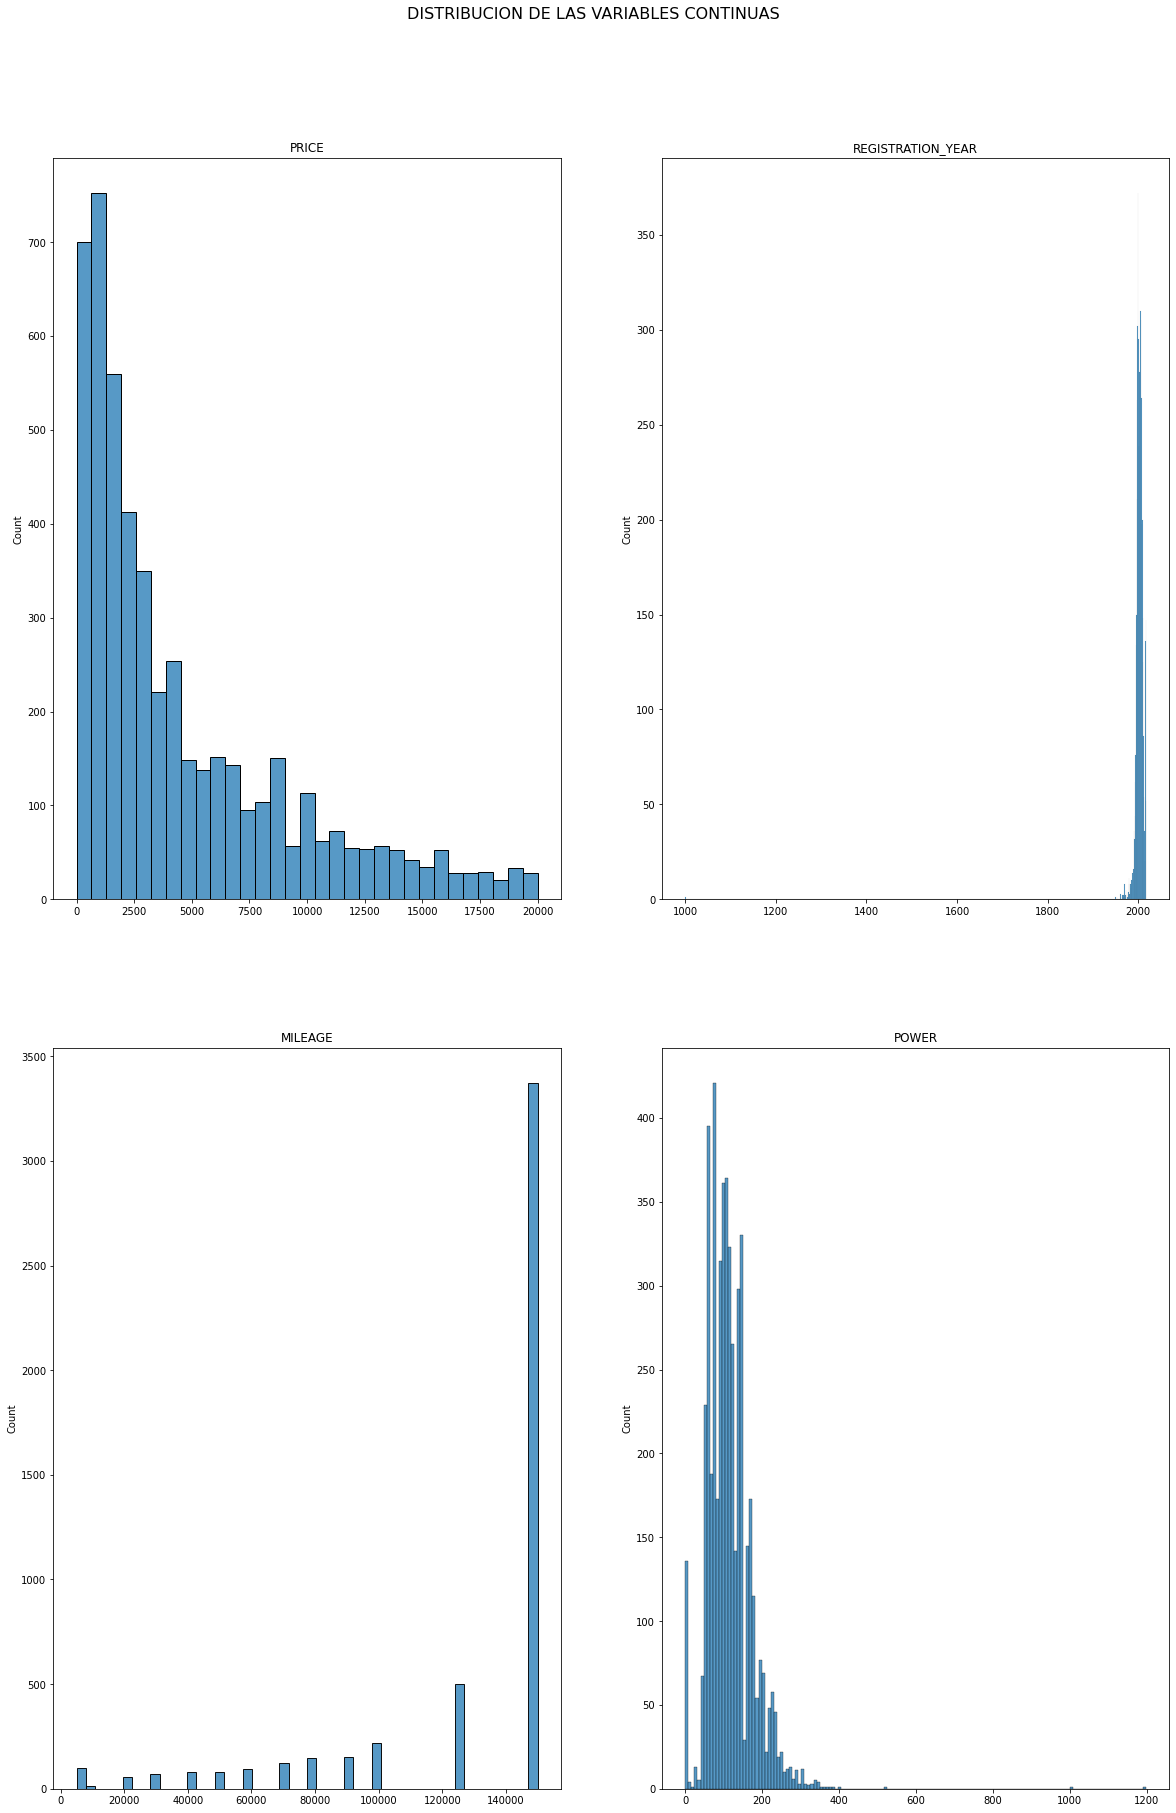

In [46]:
continuas = ['price', 'registration_year', 'mileage', 'power']

plt.figure(figsize = (20, 30)) 

plt.subplots_adjust(hspace = 0.2)

plt.suptitle('DISTRIBUCION DE LAS VARIABLES CONTINUAS', fontsize = 16, y = 0.95)

ncols = 2

nrows = len(continuas) // ncols + (len(continuas) % ncols > 0)

for n, cont in enumerate(continuas):
    ax = plt.subplot(nrows, ncols, n + 1)
    df[cont] = pd.to_numeric(df[cont], errors='coerce')
    sns.histplot(data = df, x = df[cont].sample(5000), ax = ax)
    ax.set_title(cont.upper())
    ax.set_xlabel('')
    
plt.show()

### Visualización de las Variables Categóricas

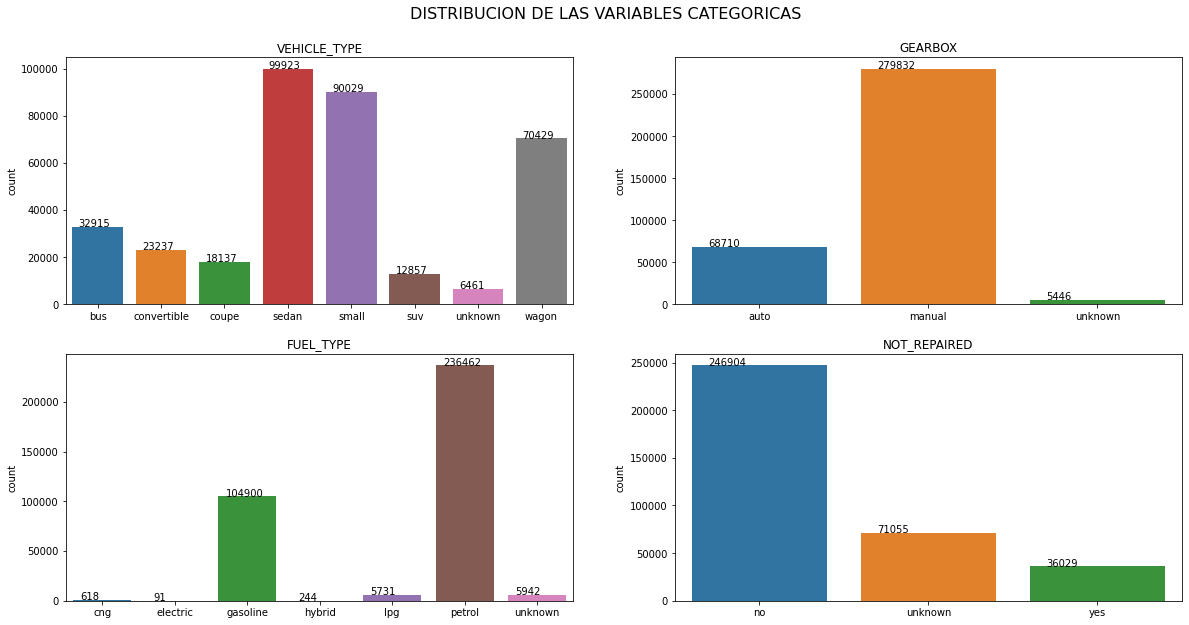

In [47]:
categoricas = ['vehicle_type', 'gearbox', 'fuel_type', 'not_repaired']

plt.figure(figsize = (20, 10)) 

plt.subplots_adjust(hspace = 0.2)

plt.suptitle('DISTRIBUCION DE LAS VARIABLES CATEGORICAS', fontsize = 16, y = 0.95)

ncols = 2

nrows = len(categoricas) // ncols + (len(categoricas) % ncols > 0)

for n, cate in enumerate(categoricas):
    ax = plt.subplot(nrows, ncols, n + 1)
    splot = sns.countplot(data = df, x = df[cate].sort_values(), ax = ax)
    for p in splot.patches:
        splot.annotate('{:.0f}'.format(p.get_height()), (p.get_x() + 0.1, p.get_height() + 100))
    ax.set_title(cate.upper())
    ax.set_xlabel('')
    
plt.show()

**Conclusiones Intermedias**:

a. Visualización de Variables Continuas:

1. En la variable precio, observamos que hay muchos autos que tienen precio de 0 euros. ¿Por qué colocar ese precio? 
2. En la variable año de registro, observamos que los autos fueron matriculados entre los años 1990 y 2017.
3. En la variable millas, la mayoría de los autos tienen más de 140.000 millas.
4. En la variable potencia, la gran mayoría de los autos tienen un motor inferior a 400 C.V.

b. Visualización de Variables Categóricas:

1. En la variable tipo de vehículo, podemos ver que los autos mas vistos son el sedan, el auto pequeño y el wagon.
2. En la variable transmisión, la gran mayoría de los autos son manual.
3. En la variable tipo de gasolina, casi todos funcionan con ella.
4. En la variable reparados, la gran mayoría no han sido reparados.



## Entrenamiento del modelo 

### Proceso de Train Test Split

In [48]:
# eliminamos las columnas innecesarias

df.drop(['date_crawled', 'registration_month', 'date_created', 
         'number_of_pictures', 'postal_code', 'last_seen'], axis = 1, inplace = True)

df.columns




Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'mileage', 'fuel_type', 'brand', 'not_repaired'],
      dtype='object')

In [49]:
# definimos las variables de entrenamiento y prueba

X = df.drop('price', axis = 1 )
y = df.loc[:, 'price']

### One-Hot Encoding

In [50]:
X_dummies = pd.get_dummies(X, drop_first = True)

X_dummies.head()

,registration_year,power,mileage,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_unknown,vehicle_type_wagon,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_unknown,not_repaired_yes
0,1993,75.0,150000,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,2011,190.0,125000,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2004,163.0,125000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,2001,75.0,150000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,2008,69.0,90000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = train_test_split(X_dummies, y, random_state = 42, test_size = 0.3)

features_train, features_test, target_train, target_test = train_test_split(X, y, random_state = 42, test_size = 0.3)

In [52]:
features_train.head()

,vehicle_type,registration_year,gearbox,power,model,mileage,fuel_type,brand,not_repaired
279147,convertible,2011,manual,160.0,mx_reihe,30000,petrol,mazda,yes
291258,small,2017,manual,50.0,ibiza,150000,petrol,seat,unknown
298055,wagon,2003,manual,141.0,6_reihe,150000,petrol,mazda,no
24306,coupe,2000,auto,170.0,3er,150000,petrol,bmw,unknown
288568,small,1998,manual,60.0,cordoba,150000,petrol,seat,no


### Ordinal Encoding

In [53]:
# definimos las columnas categóricas

X_cat = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']

In [54]:
# creamos las variables para LightGBM

X_train_enc = features_train.copy()
X_test_enc = features_test.copy()



In [55]:
# aplicamos el modelo

X_train_enc[X_cat] = OrdinalEncoder().fit_transform(X_train_enc[X_cat])
X_test_enc[X_cat] = OrdinalEncoder().fit_transform(X_test_enc[X_cat])

In [56]:
# mostramos una muestra de X_train_enc

X_train_enc.head()

,vehicle_type,registration_year,gearbox,power,model,mileage,fuel_type,brand,not_repaired
279147,1.0,2011,1.0,160.0,158.0,30000,5.0,19.0,2.0
291258,4.0,2017,1.0,50.0,120.0,150000,5.0,30.0,1.0
298055,7.0,2003,1.0,141.0,17.0,150000,5.0,19.0,0.0
24306,2.0,2000,0.0,170.0,11.0,150000,5.0,2.0,1.0
288568,4.0,1998,1.0,60.0,81.0,150000,5.0,30.0,0.0


## Análisis del modelo

### Rregresión Lineal

In [73]:
%%time

lineal = LinearRegression()
lineal.fit(X_train_ohe, y_train_ohe)

y_pred_train_lr = lineal.predict(X_train_ohe)
y_pred_test_lr = lineal.predict(X_test_ohe)

# evaluamos las métricas

print('RECM de entrenamiento:', sqrt(mean_squared_error(y_train_ohe, y_pred_train_lr)))
print('RECM de prueba:', sqrt(mean_squared_error(y_test_ohe, y_pred_test_lr)))



RECM de entrenamiento: 2955.908695383434
RECM de prueba: 2961.928191995391
CPU times: user 17.6 s, sys: 2.68 s, total: 20.3 s
Wall time: 20.2 s


### Bosque Aleatorio

In [67]:
%%time

param_grid_rf = {
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 3, 4, 5]
}

rf = RandomForestRegressor()

rf_gs = GridSearchCV(rf, param_grid=param_grid_rf, scoring='neg_mean_squared_error', cv=3)

rf_gs.fit(X_train_ohe, y_train_ohe)

y_pred_train_rf = rf_gs.predict(X_train_ohe)
y_pred_test_rf = rf_gs.predict(X_test_ohe)

train_rmse_rf = sqrt(mean_squared_error(y_train_ohe, y_pred_train_rf))
test_rmse_rf = sqrt(mean_squared_error(y_test_ohe, y_pred_test_rf))

# Imprimimos las métricas
print("Métricas del modelo de Bosque Aleatorio:")
print("Entrenamiento - RMSE:", train_rmse_rf)
print("Prueba - RMSE:", test_rmse_rf)



Métricas del modelo de Bosque Aleatorio:
Entrenamiento - RMSE: 2495.8428193122095
Prueba - RMSE: 2500.2999999276735
CPU times: user 1h 41s, sys: 8.52 s, total: 1h 50s
Wall time: 1h 51s


### XGBoost

In [69]:
%%time

param_grid_xgb = {
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3, 4, 5]}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

xgb_gs = GridSearchCV(xgb_model, param_grid=param_grid_xgb, scoring='neg_mean_squared_error', cv=3)

xgb_gs.fit(X_train_ohe, y_train_ohe)

y_pred_train_xgb = xgb_gs.predict(X_train_ohe)
y_pred_test_xgb = xgb_gs.predict(X_test_ohe)

train_rmse_xgb = sqrt(mean_squared_error(y_train_ohe, y_pred_train_xgb))
test_rmse_xgb = sqrt(mean_squared_error(y_test_ohe, y_pred_test_xgb))

print("Métricas del modelo de XGBoost:")
print("Entrenamiento - RMSE:", train_rmse_xgb)
print("Prueba - RMSE:", test_rmse_xgb)



Métricas del modelo de XGBoost:
Entrenamiento - RMSE: 1821.8687418890026
Prueba - RMSE: 1868.3781544706721
CPU times: user 2h 41min 37s, sys: 26.8 s, total: 2h 42min 3s
Wall time: 2h 42min 7s


### LightGBM

In [71]:
%%time

param_grid_lgbm = {
    'num_leaves': [10, 20, 30, 40],
    'max_depth': [3, 4, 5]}

lgbm_model = lgbm.LGBMRegressor(objective='regression')

lgbm_gs = GridSearchCV(lgbm_model, param_grid=param_grid_lgbm, scoring='neg_mean_squared_error', cv=3)

lgbm_gs.fit(X_train_ohe, y_train_ohe)

y_pred_train_lgbm = lgbm_gs.predict(X_train_ohe)
y_pred_test_lgbm = lgbm_gs.predict(X_test_ohe)

train_rmse_lgbm = sqrt(mean_squared_error(y_train_ohe, y_pred_train_lgbm))
test_rmse_lgbm = sqrt(mean_squared_error(y_test_ohe, y_pred_test_lgbm))

print("Métricas del modelo de LightGBM:")
print("Entrenamiento - RMSE:", train_rmse_lgbm)
print("Prueba - RMSE:", test_rmse_lgbm)



Métricas del modelo de LightGBM:
Entrenamiento - RMSE: 1912.5700437799992
Prueba - RMSE: 1931.1632022147448
CPU times: user 2min 40s, sys: 7.55 s, total: 2min 47s
Wall time: 2min 48s


### CatBoost

In [72]:
%%time

param_grid_cat = {
    'depth': [3, 4, 5],
    'min_data_in_leaf': [1, 2, 3, 4, 5]}

cat_model = cb.CatBoostRegressor(loss_function='RMSE', iterations=150, random_seed=42)

cat_gs = GridSearchCV(cat_model, param_grid=param_grid_cat, scoring='neg_mean_squared_error', cv=3)

cat_gs.fit(features_train, target_train, cat_features=X_cat)

y_pred_train_cat = cat_gs.predict(features_train)
y_pred_test_cat = cat_gs.predict(features_test)

train_rmse_cat = sqrt(mean_squared_error(target_train, y_pred_train_cat))
test_rmse_cat = sqrt(mean_squared_error(target_test, y_pred_test_cat))

print("Métricas del modelo de CatBoost:")
print("Entrenamiento - RMSE:", train_rmse_cat)
print("Prueba - RMSE:", test_rmse_cat)




Learning rate set to 0.429003
0:	learn: 3643.4974162	total: 150ms	remaining: 22.3s
1:	learn: 3195.5384350	total: 245ms	remaining: 18.1s
2:	learn: 2882.2308252	total: 326ms	remaining: 16s
3:	learn: 2685.3025258	total: 415ms	remaining: 15.1s
4:	learn: 2556.5650168	total: 510ms	remaining: 14.8s
5:	learn: 2485.9664742	total: 588ms	remaining: 14.1s
6:	learn: 2425.0223572	total: 669ms	remaining: 13.7s
7:	learn: 2387.0526501	total: 748ms	remaining: 13.3s
8:	learn: 2342.8897531	total: 823ms	remaining: 12.9s
9:	learn: 2306.5229566	total: 901ms	remaining: 12.6s
10:	learn: 2286.1780648	total: 987ms	remaining: 12.5s
11:	learn: 2268.3843154	total: 1.06s	remaining: 12.2s
12:	learn: 2236.0565806	total: 1.14s	remaining: 12s
13:	learn: 2224.2888405	total: 1.22s	remaining: 11.9s
14:	learn: 2211.9150576	total: 1.29s	remaining: 11.7s
15:	learn: 2199.9575646	total: 1.37s	remaining: 11.5s
16:	learn: 2187.2386398	total: 1.45s	remaining: 11.4s
17:	learn: 2171.2579949	total: 1.53s	remaining: 11.2s
18:	learn: 2

**Conclusiones Intermedias:**

Con los resultados obtenidos despuesde aplicar el objeto GridSearchCV, podemos tener en cuenta lo siguiente:
    
* Con la calidad de predicción, los modelos que mejores datos dan son los modelos XGBoost, LightGBM y CatBoost, al tener un conjunto de entrenamiento y prueba mas bajo en comparación con regresión lineal y bosque aleatorio.
    
* Con la velocidad de predicción, los mas rapidos son regresion lineal y bosque aleatorio, mientras que los otros duran mas considerablemente.
    
* Con el tiempo requerido para el entrenamiento

Tiempo requerido para el entrenamiento: El tiempo requerido para el entrenamiento es significativamente más alto en los modelos más complejos (XGBoost, LightGBM y CatBoost) en comparación con la Regresión Lineal y el Bosque Aleatorio. El entrenamiento de los modelos más complejos puede llevar horas, mientras que la Regresión Lineal y el Bosque Aleatorio se entrenan en cuestión de segundos o minutos.

En resumen, si Rusty Bargain busca una predicción más precisa y está dispuesto a sacrificar el tiempo de entrenamiento, entonces los modelos más complejos como XGBoost, LightGBM y CatBoost son más adecuados. Por otro lado, si la velocidad de entrenamiento y predicción es crítica, la Regresión Lineal y el Bosque Aleatorio pueden ser opciones más viables, aunque pueden tener un rendimiento ligeramente inferior en términos de precisión de predicción. La elección del modelo dependerá de los requisitos específicos de Rusty Bargain y el equilibrio que desee alcanzar entre calidad de predicción y tiempo requerido para el entrenamiento y predicción.

# Conclusiones

**1. Preparación de datos:**

Nos encontramos con un DataFrame con varias columnas que presentaban valores ausentes y duplicados, llegando casi al 20% de los datos. Se rellenaron los valores, se eliminaron los duplicados y también aquellos que no se pudieron rellenar. Asimismo, aparecieron valores anormales, especificamente en la columna 'power' y 'registration_year'.

**2. EDA**

a. Visualización de Variables Continuas:

1. En la variable precio, observamos que hay muchos autos que tienen precio de 0 euros. ¿Por qué colocar ese precio? 
2. En la variable año de registro, observamos que los autos fueron matriculados entre los años 1990 y 2017.
3. En la variable millas, la mayoría de los autos tienen más de 140.000 millas.
4. En la variable potencia, la gran mayoría de los autos tienen un motor inferior a 400 C.V.

b. Visualización de Variables Categóricas:

1. En la variable tipo de vehículo, podemos ver que los autos mas vistos son el sedan, el auto pequeño y el wagon.
2. En la variable transmisión, la gran mayoría de los autos son manual.
3. En la variable tipo de gasolina, casi todos funcionan con ella.
4. En la variable reparados, la gran mayoría no han sido reparados.

**3. Entrenamiento del Modelo:**

Dividimos los datos en dos grupos, un conjunto de entrenamiento y otro de prueba con una proporción 70:30. Asimimsmo, aplicamos el one-hot debido que los modelos de regresion lineal, Bosque Aleatorio y XGBoost requieren datos categoricos en formato OHE.
Debido a que tenemos que aplicar el modelo LightGBM, tuvimos que aplicar un Ordinal Encoding.
Con respecto al CatBoost, este puede leer datos en forma de objeto.


**4. Análisis del Modelo:**

1. Con respecto al modelo de Bosque Aleatorio, el tiempo es relativamente corto cuando se configuta el parametro de pronfudidad de 10 niveles.

2. El modelo XGBoost es el que más tarda en entrenar los datos, teniendo como configuración en cinco niveles los parametros de profundidad. 

3. El modelo LightGBM es el que posee el tiempo de entrenamiento mas corto, pero los resultados no son mejores que los de XGBoost.

4. El modelo CatBoost es el modelo con mejores resultados, pero al tardar un poco más que el modelo LightGBM, es el que ofrece mejores resultados con parametros de profundiad de hasta 10 niveles. 


Para efectos de la solicitud del cliente sobre la calidad de predicción, la velocidad de predicción y el tiempo requerido para el entrenamiento, recomendamos **El Modelo CatBoost**, ya que es el más equilibridado de todos los que existen.



# Lista de control

Escribe 'x' para verificar. Luego presiona Shift+Enter

- [x]  Jupyter Notebook está abierto
- [ ]  El código no tiene errores- [ ]  Las celdas con el código han sido colocadas en orden de ejecución- [ ]  Los datos han sido descargados y preparados- [ ]  Los modelos han sido entrenados
- [ ]  Se realizó el análisis de velocidad y calidad de los modelos